<h1 id="tocheading">Table of Contents</h1>
<div id="toc"></div>

In [1]:
%%javascript
$.getScript('https://kmahelona.github.io/ipython_notebook_goodies/ipython_notebook_toc.js')

<IPython.core.display.Javascript object>

# Basics of Transit Anslysis

## Unique observables:
* Primary Transit
 * relative dimensions of the planet and its host star, 
 * orientation of the planet’s orbit relative to the sky plane and relative to the stellar rotation axis
* Occultation/Secondary Eclipse
 * wavelength-dependence of the eclipse signal -> planet’s orbit, mass, radius, temperature, and atmospheric constituents
* TTV
 * presence of additional planets or moons

## Data Reduction
1. Linearity/ Systematics correction 
2. 

## Lightcurve Modeling
Stellar intensity profile can be fit with several functional forms, including a 
* linear limb darkening law (Schwarzschild & Villiger 1906), 
* quadratic (Kopal 1950), 
* square-root (Diaz-Cordoves & Gimenez 1992), 
* logarithmic (Klinglesmith & Sobieski 1970), 
* exponential (Claret & Hauschildt 2003), and 
* four-parameter nonlinear (Claret 2000). 

For some of these profiles, model transit light curves can be calculated analytically, e.g.:
* Mandel & Agol 2002 
 - provide Fortran and IDL routines to compute models for quadratic and nonlinear limb darkening laws
 - TAP by Gazak et al. 2012 is a wavelet-based likelihood function in IDL by Carter & Winn (2009) that accounts for correlated noise (of very specific statistical characteristics) in the photometry
 - EXOFAST by Eastman et al. 2013 includes IDL implementations of the Mandel & Agol (2002) algorithm for quadratic limb darkening;
* Gimenez 2006; 
 - `PyTransit` ([paper](https://arxiv.org/pdf/1504.07433.pdf), [code](https://github.com/hpparvi/PyTransit )) by Parviainen 2015 is a Python package implementation of Mandel & Agol (2002) and Gimenez (2006) models
* Abubekerov & Gostev 2013 
* Kjurkchieva et al. (2013) 
 - pure Python code TAC-maker for arbitrary limb darkening profiles 
* `BaTMAN` ([paper](https://arxiv.org/abs/1507.08285), [code](https://github.com/lkreidberg/batman)) by Laura Kriedberg (2015) model with radially symmetric limb-darkening law; supports secondary eclipse modeling
* update of PlanetPack by Baluev (2014) is a command-line program in C++ for transit modelling using the Abubekerov & Gostev transit model and several correlated noise models 
Other profiles do not have analytic solutions, and models must be calculated by numeric integration of the stellar intensity over the disk of the planet. (Kriedberg 2015)

* simultaneous transits by one or more bodies (Kipping 2011; Pal 2012)
*  Bayesian approach to inference with Markov Chain Monte Carlo (MCMC) sampling for the posterior estimation

## Periodicity-fitting algorithm
* Box-Least Squares (BLS) ([paper](http://www.aanda.org/articles/aa/pdf/2002/31/aa2422.pdf), [code](https://github.com/hpparvi/PyBLS))
* [python-bls](https://github.com/dfm/python-bls)
* K2 Planet Search (`k2ps`) by Parviainen et al. ([code](https://github.com/hpparvi/k2ps))
* `Terra` by E. Petigura ([code](https://github.com/petigura/terra))

References:
* Fundamentals
 - [Transit and Occultations](https://arxiv.org/pdf/1001.2010.pdf)

<img src="figures/transit.png" width="600">

where

* time is an N-dimensional array of timestamps for the light curve,
* flux is the N-dimensional light curve array,
* u and v are N-dimensional empty work arrays,
* nf is the number of frequency bins to test,
* fmin is the minimum frequency to test,
* df is the frequency grid spacing,
* nb is the number of bins to use in the folded light curve,
* qmi is the minimum transit duration to test, and
* qma is the maximum transit duration to test.
The returned values are

power, best_period, best_power, depth, q, in1, in2 = results

# Analysing Transit Lightcurve

# Import and plot data

In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import pandas as pd

filename = 'planet.txt'
df = pd.read_table(filename, delim_whitespace=True, names=['t','f'], skiprows=1)
df.head()

t         f
0  3156.464686  1.000748
1  3156.485119  1.000596
2  3156.505551  1.000568
3  3156.525983  1.000533
4  3156.546416  1.000474

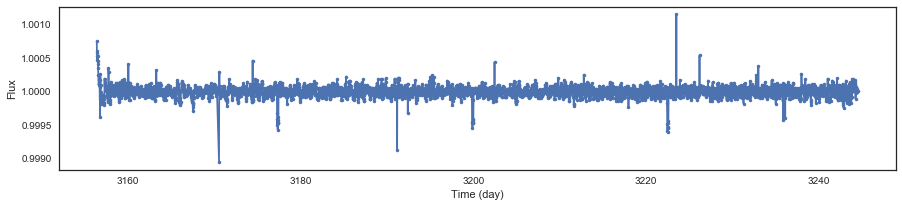

In [3]:
import seaborn as sb
with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.plot(df.t, df.f, '.-')
    ax.set_ylabel('Flux')
    ax.set_xlabel('Time (day)')

In [58]:
len(df.f)

4205

In [62]:
np.sum(df.f<1.0001)

3939

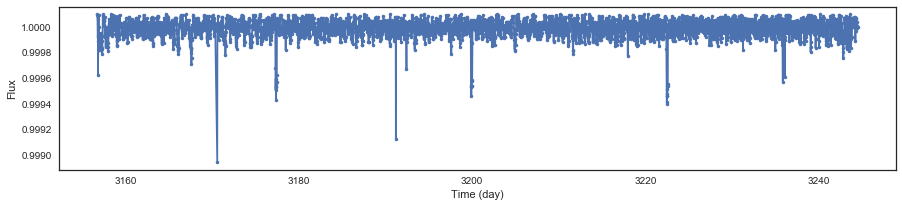

In [64]:
df = df[df.f<1.0001]#.dropna()

with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.plot(df.t, df.f, '.-')
    ax.set_ylabel('Flux')
    ax.set_xlabel('Time (day)')

In [65]:
#dfm's package
import bls

t,f  = df.t, df.f
u,v  = np.ones_like(t), np.ones_like(t)
nf   = 5
fmin = 0.05
delf = 0.01
nb   = 20
qmi  = 0.1
qma  = 0.3

results = bls.eebls(t, f, u, v, nf, fmin, delf, nb, qmi, qma)
results

(array([  4.17947364e-06,   3.35512746e-06,   6.27482078e-06,
          3.38523931e-06,   6.14270334e-06]),
 14.285714285714285,
 6.27482077629442e-06,
 2.0570189849309516e-05,
 0.10383346026910384,
 20,
 1)

In [66]:
power, best_period, best_power, depth, q, in1, in2 = results

# Find period of transit occurrence: periodogram

In [67]:
import gatspy
from gatspy.periodic import LombScargleFast

t, f = df.t.values, df.f.values   
f /= np.median(f)                 #normalize

model = LombScargleFast().fit(t, f)
periods, power = model.periodogram_auto(nyquist_factor=100)

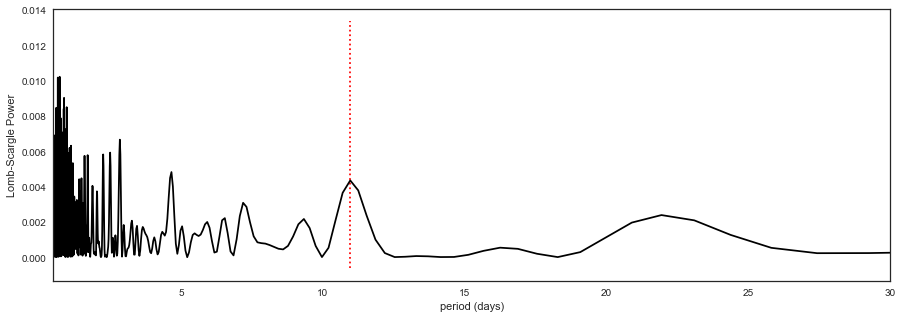

In [68]:
#I assume period is about 25 days based above
idx1 = periods > 10
idx2 = np.argmax(power[idx1])
peak = periods[idx1][idx2]

with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.plot(periods, power, 'k-')
    ax.set(xlim=(0.5, 30),
#         , ylim=(0, 0.01),
       xlabel='period (days)',
       ylabel='Lomb-Scargle Power')
    ax.vlines(peak, *ax.get_ylim(), linestyles='dotted', colors='r')

# Estimate transit midpoint, $t_0$

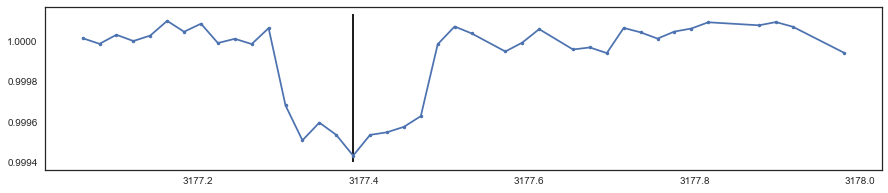

In [69]:
idx = (3177 < t) & (t < 3178)
tsub, fsub = t[idx], f[idx]
idx = fsub < np.median(fsub) - 0.5 * np.std(fsub)
t0 = np.median(tsub[idx])

with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,3))
    ax.plot(tsub, fsub, '.-')
    ax.vlines(t0, *ax.get_ylim())

In [70]:
# import bls
# t, f = df2.t, df2.f
# u = np.empty_like(t)
# v = np.empty_like(t)
# nf = 2000
# fmin = 1
# df = 1e-4
# nb = 1e4
# qmi = 0.02
# qma = 0.5
# results = bls.eebls(t, f, u, v, nf, fmin, df, nb, qmi, qma)
# power, best_period, best_power, depth, q, in1, in2 = results
# print 'best_period:', best_period
# print 'best_power:', best_power
# print 'depth:', depth/f.median()
# print 'q:', q
# print 'in1:', in1
# print 'in2:', in2

# Phase-fold lightcurve

In [71]:
#import simfit
#tf, ff = simfit.util.fold(t, f, peak, t0)

def get_tns(t, p, t0):

    idx = t != 0
    t = t[idx]

    while t0-p > t.min():
        t0 -= p
    if t0 < t.min():
        t0 += p

    tns = [t0+p*i for i in range(int((t.max()-t0)/p+1))]

    while tns[-1] > t.max():
        tns.pop()

    while tns[0] < t.min():
        tns = tns[1:]

    return tns


def extract_individual(star, p, t0, width=1):

    t, f = star.time, star.flux
    idx = np.isfinite(t) & np.isfinite(f)
    t, f = t[idx], f[idx]

    tns =  get_tns(t, p, t0)

    transits = []
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        if idx.sum() == 0:
            continue
        ti = t[idx].tolist()
        fi = f[idx].tolist()
        transits.append((ti,fi))

    return transits

def fold(t, f, p, t0, width=0.4, clip=False, bl=False, t14=0.2):
    tns = get_tns(t, p, t0)
    tf, ff = np.empty(0), np.empty(0)
    for i,tn in enumerate(tns):
        idx = (t > tn - width/2.) & (t < tn + width/2.)
        ti = t[idx]-tn
        fi = f[idx]
        fi /= np.nanmedian(fi)
        if bl:
            idx = (ti < -t14/2.) | (ti > t14/2.)
            assert np.isfinite(ti[idx]).all() & np.isfinite(fi[idx]).all()
            assert idx.sum() > 0
            try:
                res = sm.RLM(fi[idx], sm.add_constant(ti[idx])).fit()
                if np.abs(res.params[1]) > 1e-2:
                    print('bad data probably causing poor fit')
                    print('transit {} baseline params: {}'.format(i, res.params))
                    continue
                model = res.params[0] + res.params[1] * ti
                fi = fi - model + 1
            except:
                print("error computing baseline for transit {}".format(i))
                print("num. points: {}".format(idx.sum()))
                print(ti)
        tf = np.append(tf, ti)
        ff = np.append(ff, fi / np.nanmedian(fi))
    idx = np.argsort(tf)
    tf = tf[idx]
    ff = ff[idx]
    if clip:
        fc = sigma_clip(ff, sigma_lower=10, sigma_upper=2)
        tf, ff = tf[~fc.mask], ff[~fc.mask]
    return tf, ff

In [72]:
peak

10.969342125000026

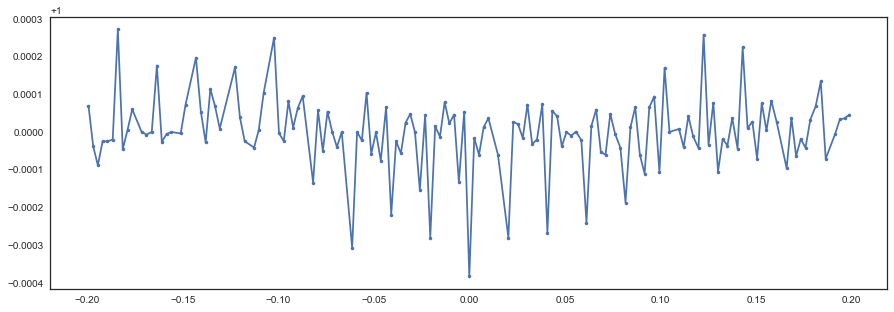

In [75]:
#peak = 21.5
#peak = np.copy(best_period)*2

tf, ff = fold(t, f, peak, t0)
with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.plot(tf, ff, '.-')

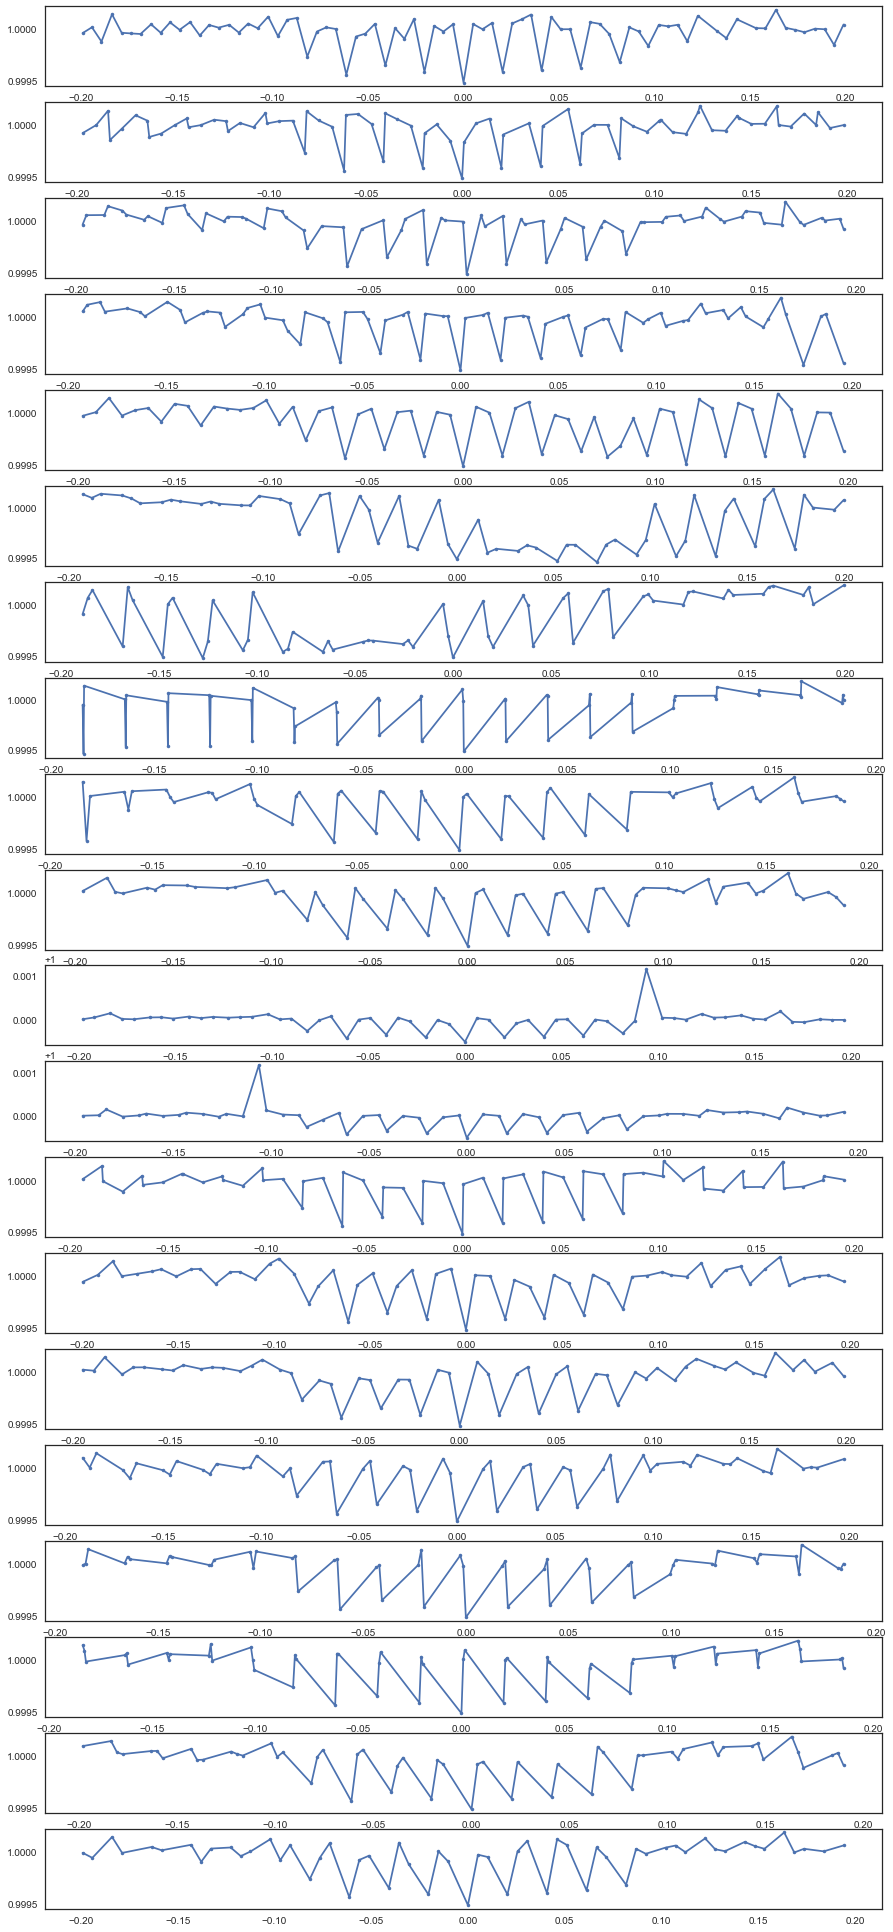

In [12]:
#manual search for correct period
n=0
fig = plt.figure(figsize=(15,35))
with sb.axes_style('white'):
    for i in np.arange(22,24,0.1):
        tf, ff = fold(t, f, i, t0)
        ax = plt.subplot(20,1,n+1)
        ax.plot(tf, ff, '.-')
        n+=1

# Plot analytical lightcurve (Mandel-Agol) and minimize error

In [10]:
from pytransit import MandelAgol

MA = MandelAgol()


def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model


def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    #prior
    if np.any(theta[:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf
    #loglike
    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

In [11]:
p = peak
t14 = 0.15
k = np.sqrt(1-0.993)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
lna = 1e-1
lntau = 1
initial = k,t0,p,a,i,u1,u2,sig,0,0,0,0
args = (t, f)

nlp = lambda *args: -lnprob(*args)

import scipy.optimize as op

opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print(opt.success)
print(opt.x)

False
[  7.75790205e-02   1.21711206e+03   2.20472992e+00   4.79316958e+00
   1.57073502e+00   2.02126338e-01   2.00468646e-01   3.07066523e-04
  -2.55137036e-05  -4.67654919e-06   2.90020436e-07   4.06485242e-09]


### opt.x[1], opt.x[2]

In [12]:
t, f, p, t0

(array([ 1215.69352721,  1215.70033854,  1215.70714997, ...,  1239.98041171,
         1239.98722306,  1239.9940345 ]),
 array([ 0.99969546,  0.99991937,  0.99969093, ...,  0.99942094,
         0.99946361,  0.99982   ]),
 2.2091370267745458,
 1217.1143924071348)

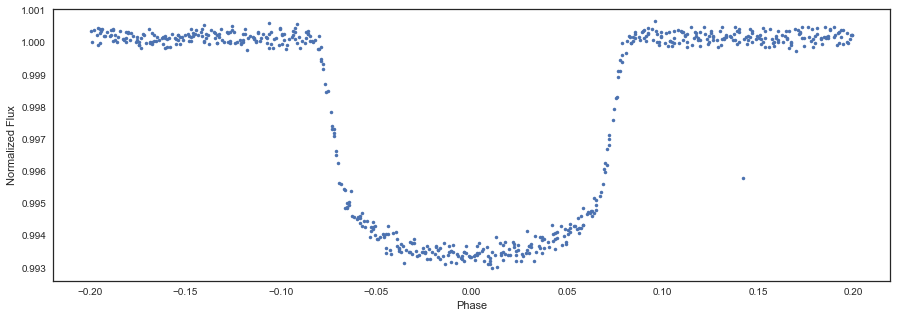

In [13]:
t0, p = opt.x[1], opt.x[2]

tf, ff = fold(t, f, p, t0)
ff /= np.median(ff)

with sb.axes_style('white'):
    fig, ax = plt.subplots(1,1,figsize=(15,5))
    ax.plot(tf, ff, '.')
    plt.xlabel('Phase')
    plt.ylabel('Normalized Flux')

# Run mcmc

Estimate planet and star properties based on optimized lightcurve

In [32]:
from emcee import EnsembleSampler
from emcee.utils import sample_ball

# initial = opt.x

ndim = len(initial)
nwalkers = 8 * ndim
nsteps1 = 500
nsteps2 = 3000

sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=args, threads=4)
pos0 = sample_ball(initial, [1e-1]*ndim, nwalkers)

width = 30
print("\nstage 1")
for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps1)):
    n = int((width+1) * float(i) / nsteps1)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))

print("\nstage 2")
idx = np.argmax(sampler.lnprobability)
best = sampler.flatchain[idx]
pos0 = sample_ball(best, [1e-5]*ndim, nwalkers)
sampler.reset()
for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps2)):
    n = int((width+1) * float(i) / nsteps2)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))


stage 1
[                              ]

/home/dl/miniconda2/envs/transit/lib/python3.5/site-packages/emcee/ensemble.py:335: RuntimeWarning: invalid value encountered in subtract
  lnpdiff = (self.dim - 1.) * np.log(zz) + newlnprob - lnprob0
/home/dl/miniconda2/envs/transit/lib/python3.5/site-packages/emcee/ensemble.py:336: RuntimeWarning: invalid value encountered in greater
  accept = (lnpdiff > np.log(self._random.rand(len(lnpdiff))))


[##############################]
stage 2
[##############################]

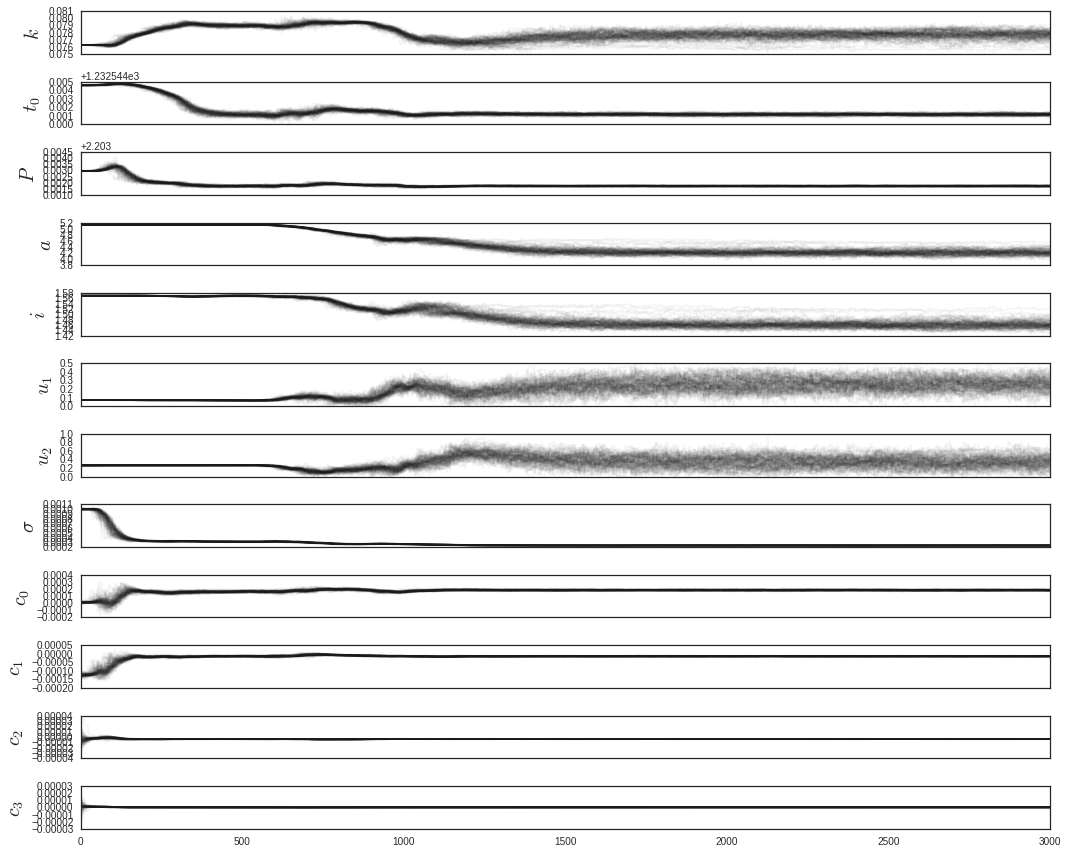

In [128]:
chain = sampler.chain
labels = ['${}$'.format(i) for i in r'k,t_0,P,a,i,u_1,u_2,\sigma,c_0,c_1,c_2,c_3'.split(',')]
with sb.axes_style('white'):
    fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    for i,ax in enumerate(axs):
        ax.set_ylabel(labels[i], fontsize=20)
    fig.tight_layout()

## Posterior Probability Distribution of parameters  

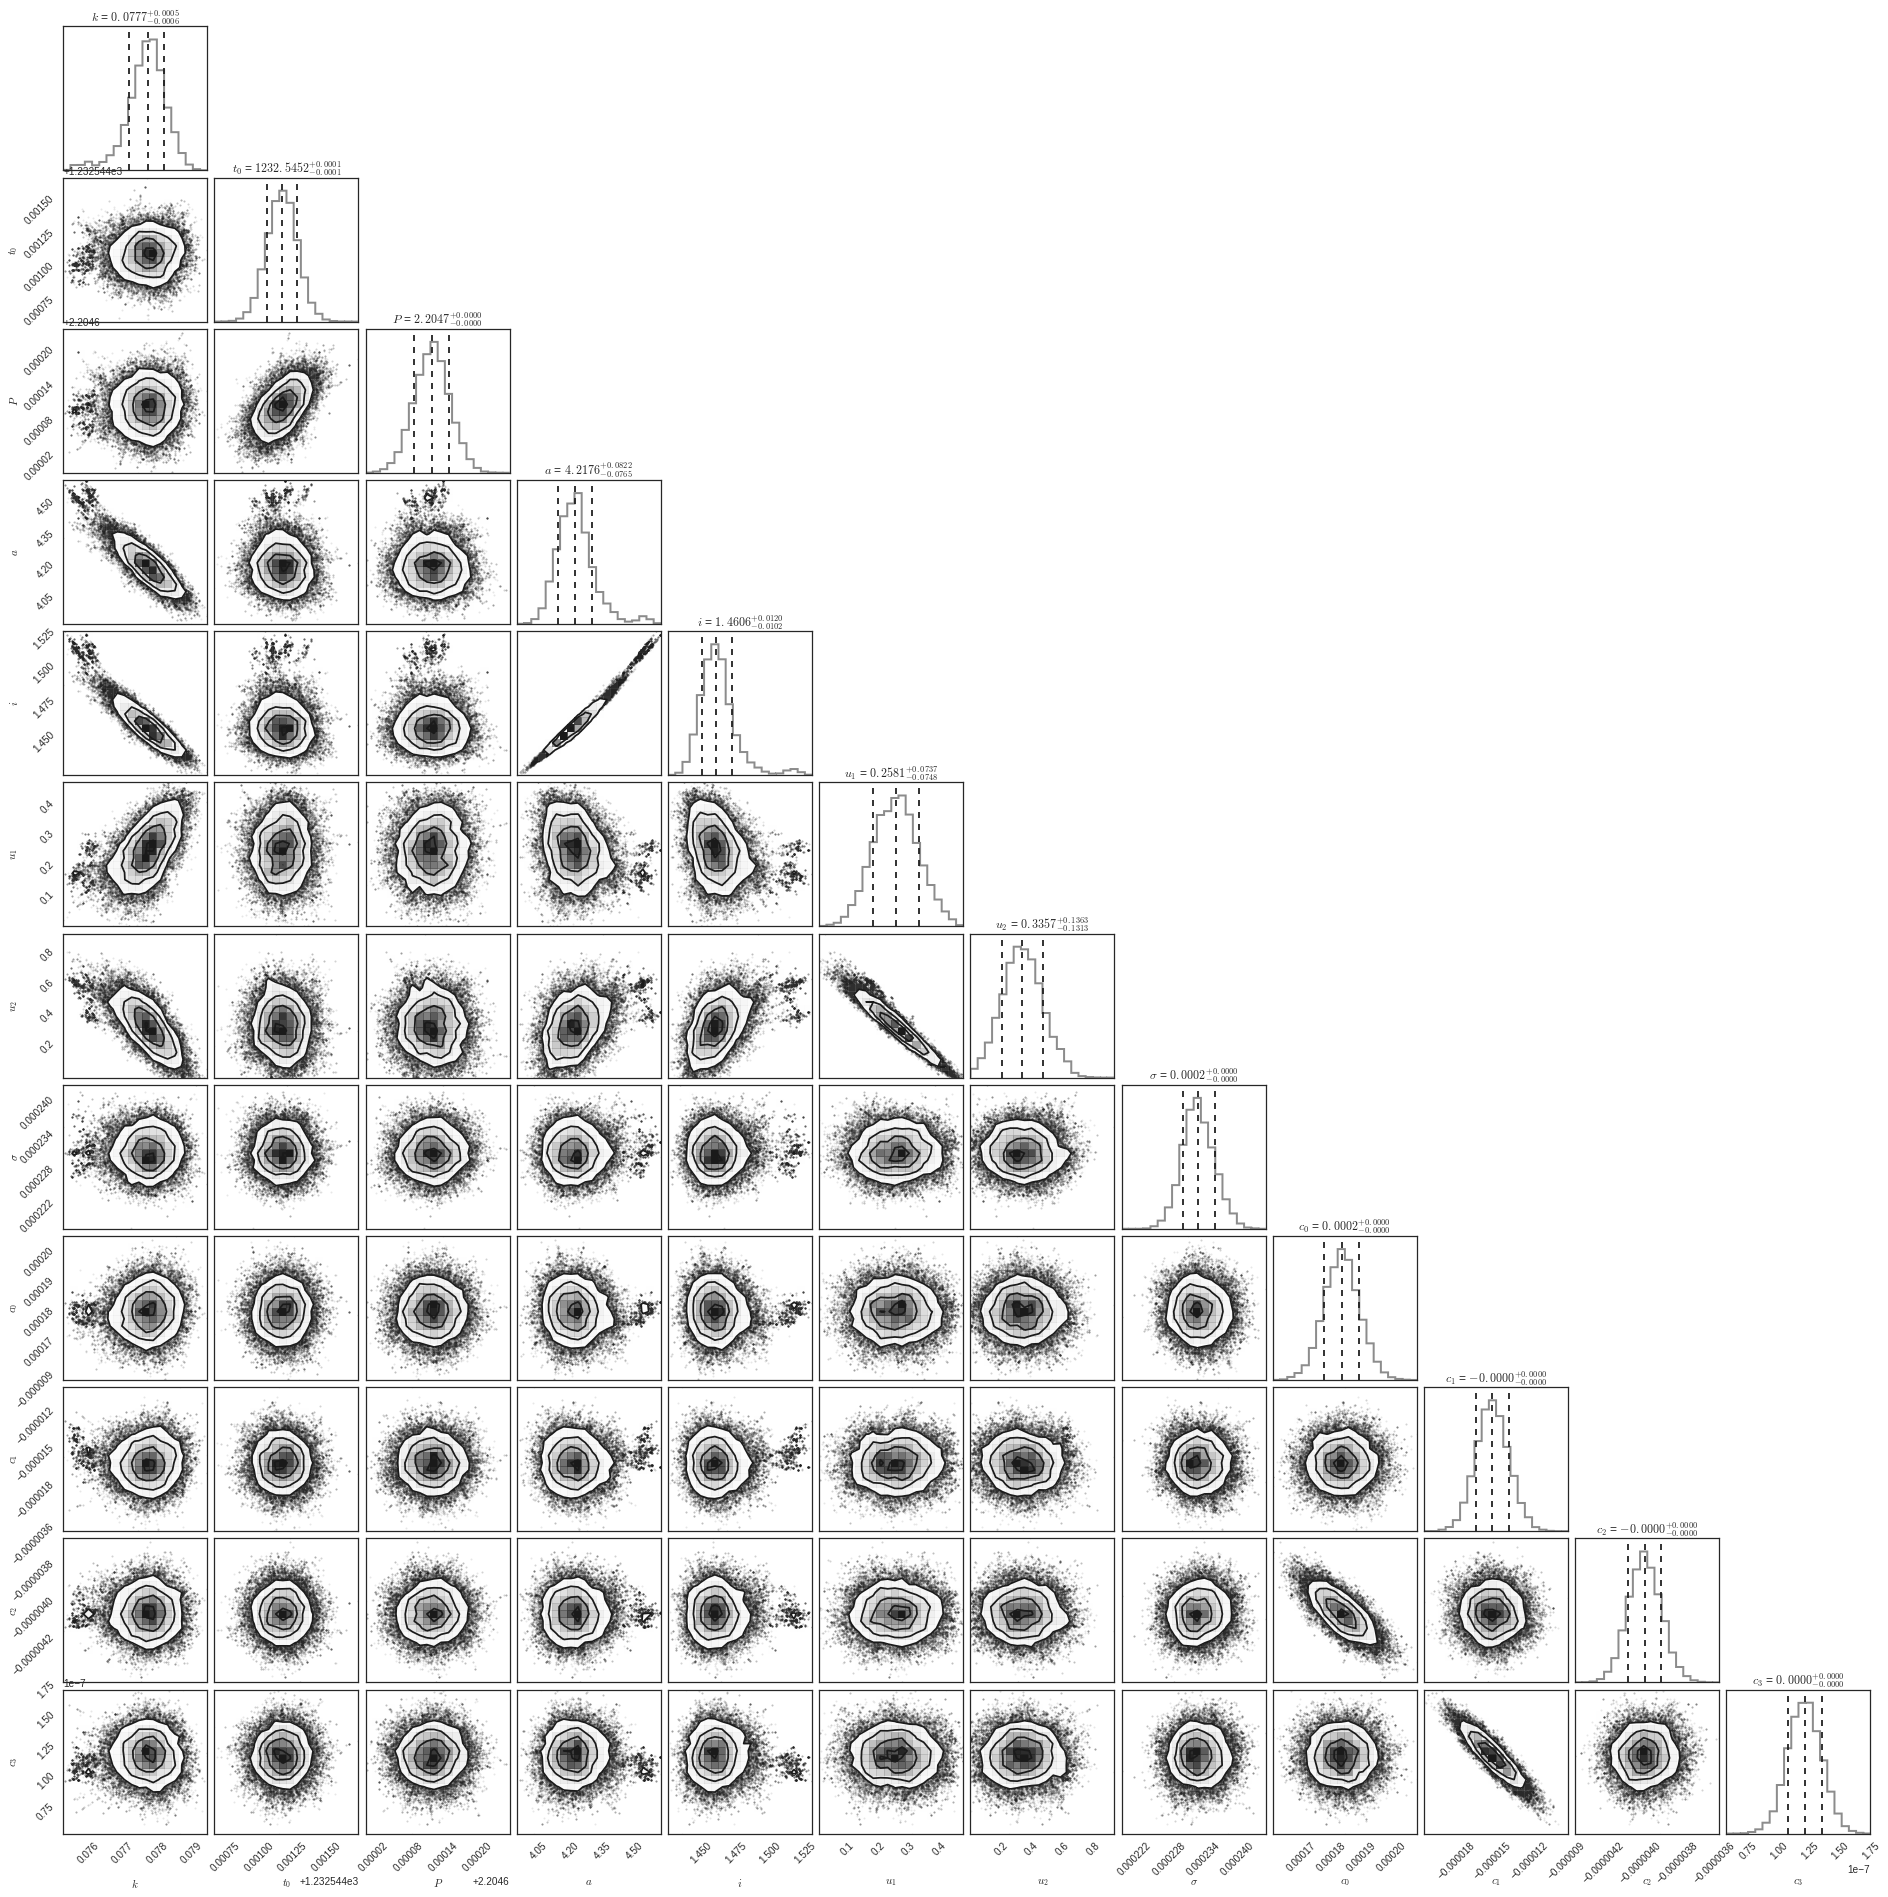

In [129]:
import corner
burn = 2000
thin = 1
fc = chain[:,burn::thin,:].reshape(-1, ndim)
hist_kwargs = dict(lw=2, alpha=0.5)
title_kwargs = dict(fontdict=dict(fontsize=12))

pl.figure()
with sb.axes_style('white'):
    corner.corner(fc, 
                  labels=labels,
#                   truths=truths,
                  hist_kwargs=hist_kwargs,
                  title_kwargs=title_kwargs,
                  show_titles=True, 
                  quantiles=[0.16,0.5,0.84],
                  title_fmt='.4f')
#     fig.tight_layout()

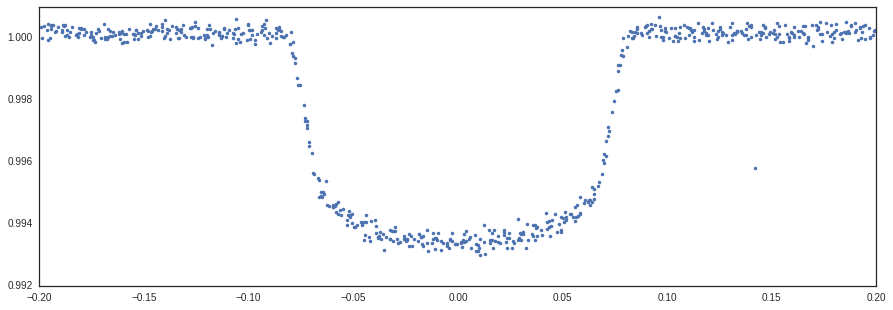

In [130]:
med = np.median(fc, axis=0)
t0 = med[1]
p = med[2]

tf, ff = simfit.util.fold(t, f, p, t0)
ff /= np.median(ff)
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,5))
    ax.plot(tf, ff, '.')

# Superpose analytical lightcurve from raw lightcurve

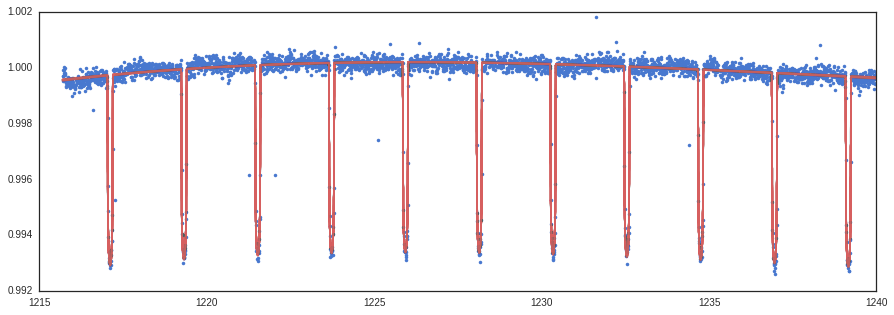

In [131]:
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,5))
    ax.plot(t, f, 'b.')
    for s in fc[np.random.randint(len(fc), size=128)]:
        ax.plot(t, model(s, t)+baseline(s, t), 'r-', alpha=0.05)

# Remove systematics (detrending)

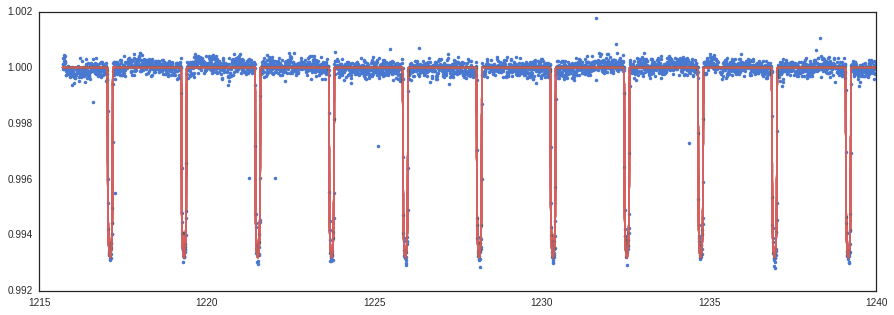

In [132]:
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,5))
    ax.plot(t, f-baseline(s, t), 'b.')
    for s in fc[np.random.randint(len(fc), size=128)]:
        ax.plot(t, model(s, t), 'r-', alpha=0.05)

# Optimized phase-folded lightcurve

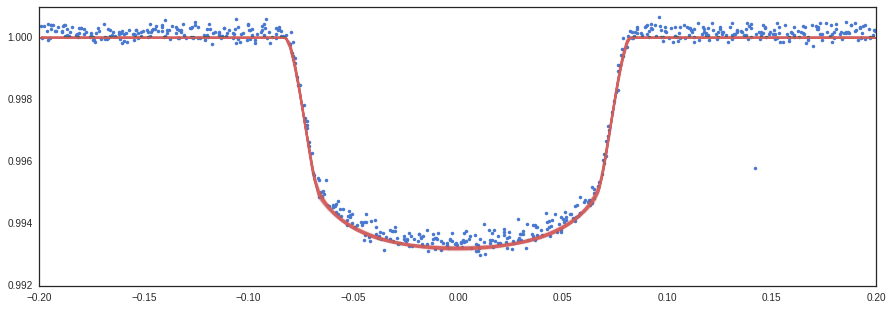

In [133]:
sb.palettes.set_color_codes(palette='muted')

fcor = f - baseline(med, t)
tf, ff = simfit.util.fold(t, fcor, p, t0)
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,5))
    ax.plot(tf, ff, 'b.')
    for s in fc[np.random.randint(len(fc), size=128)]:
        s[1] = 0
        ax.plot(tf, model(s, tf), 'r-', alpha=0.05)

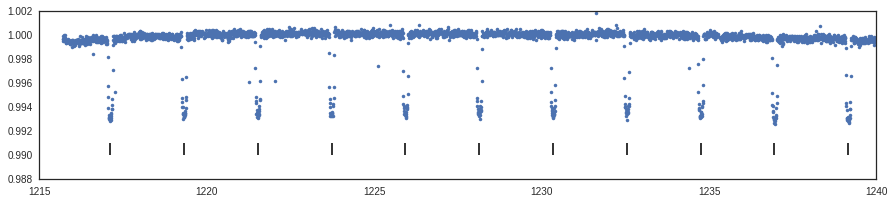

In [134]:
tns = simfit.util.get_tns(t, p, t0)

with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,3))
    ax.plot(t, f, '.')
    ax.vlines(tns, 0.99, 0.991)

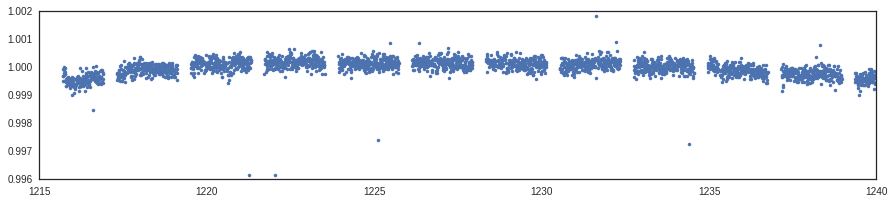

In [135]:
intransit = np.zeros_like(t).astype(bool)
t14 = 0.4
for tn in tns:
    idx = (t > tn - t14/2.) & (t < tn + t14/2.)
    intransit = np.logical_or(intransit, idx)
#     pl.plot(idx)

with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,3))
    ax.plot(t[~intransit], f[~intransit], '.')

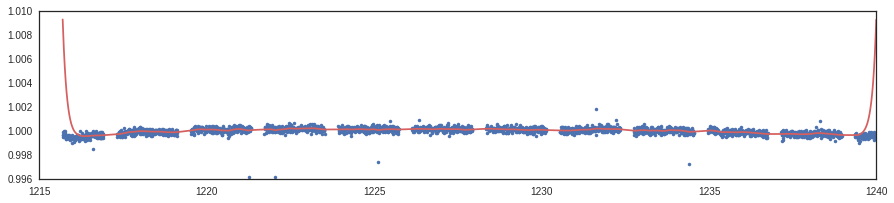

In [136]:
from scipy.interpolate import Rbf
rbfi = Rbf(t[~intransit], f[~intransit], smooth=500)

with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,3))
    ax.plot(t[~intransit], f[~intransit], '.')
    ax.plot(t, rbfi(t), 'r-')

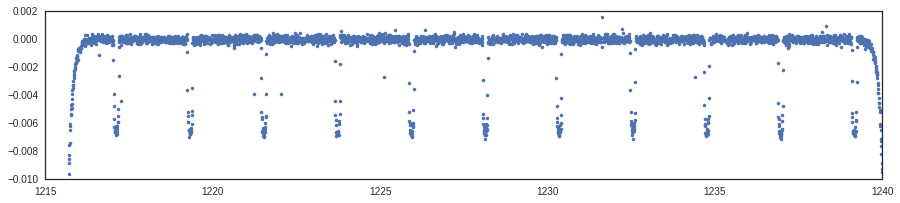

In [137]:
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,3))
    ax.plot(t, f - rbfi(t), '.')

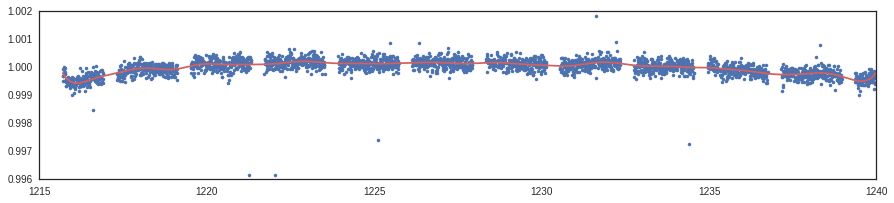

In [138]:
from scipy.interpolate import Rbf
rbfi = Rbf(t[~intransit], f[~intransit], function='quintic', smooth=10)

with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,3))
    ax.plot(t[~intransit], f[~intransit], '.')
    ax.plot(t, rbfi(t), 'r-')

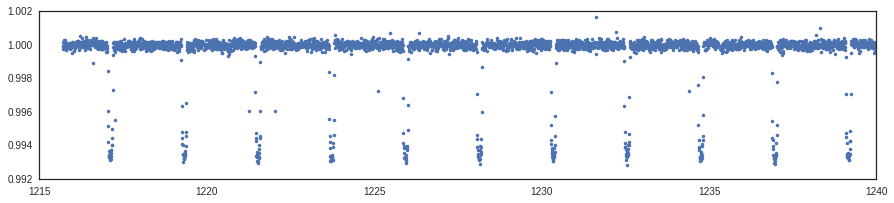

In [139]:
fcor = f - rbfi(t) + 1
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,3))
    ax.plot(t, fcor, '.')

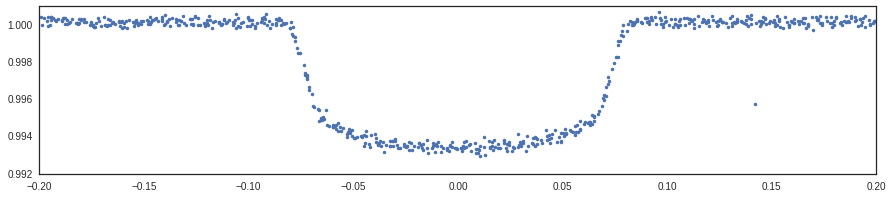

In [140]:
tf, ff = simfit.util.fold(t, fcor, p, t0)
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,3))
    ax.plot(tf, ff, '.')

# Re-run modelling to get better parameters 

In [146]:
from pytransit import MandelAgol

MA = MandelAgol()


def model(theta, t):
    
    k,t0,p,a,i,u1,u2,_,_,_,_,_ = theta
    model = MA.evaluate(t, k, (u1,u2), t0, p, a, i)
    
    return model


def baseline(theta, t):
    ti = t - t.mean()
    c0,c1,c2,c3 = theta[-4:]
    return c0 + c1 * ti + c2 * ti**2 + c3 * ti**3
    
    
def lnlike(theta, t, f):
    
    k,t0,p,a,i,u1,u2,sig,c0,c1,c2,c3 = theta
    m = model(theta, t) + baseline(theta, t)
    resid = f - m
    inv_sigma2 = 1.0/(sig**2)

    return -0.5*(np.sum((resid)**2*inv_sigma2 - np.log(inv_sigma2)))


def lnprob(theta, t, f):
    
    if theta[0] < 0:
        return -np.inf
    if np.any(theta[2:-4] < 0):
        return -np.inf
    if theta[4] > np.pi/2.:
        return -np.inf

    ll = lnlike(theta, t, f)
    return ll if np.isfinite(ll) else -np.inf


def scaled_a(p, t14, k, i=np.pi/2.):
    numer = np.sqrt( (k + 1) ** 2 )
    denom = np.sin(i) * np.sin(t14 * np.pi / p)
    return float(numer / denom)

p = peak
t14 = 0.15
k = np.sqrt(1-0.993)
i = np.pi/2.
a = scaled_a(p, t14, k, i)
u1, u2 = 0.2, 0.2
sig = f.std()
initial = k,0,p,a,i,u1,u2,sig,0,0,0,0
args = (tf, ff)

nlp = lambda *args: -lnprob(*args)
import scipy.optimize as op
opt = op.minimize(nlp, initial, args=args, method='nelder-mead')
print opt.success
print opt.x

True
[  7.77199326e-02  -5.43055221e-05   2.81745696e+00   5.34288491e+00
   1.48158927e+00   3.23611334e-01   2.20267947e-01   2.50879466e-04
   1.62602440e-04  -2.40332256e-04   1.99714189e-04   8.25123401e-03]


The values above are the result of the modelling: star-planet radii ratio, transit midpoint, semi-major axis, inclination, impact parameter, etc.

In [147]:
from emcee import EnsembleSampler
from emcee.utils import sample_ball

# initial = opt.x

ndim = len(initial)
nwalkers = 8 * ndim
nsteps1 = 500
nsteps2 = 3000

sampler = EnsembleSampler(nwalkers, ndim, lnprob, args=args, threads=4)
pos0 = sample_ball(initial, [1e-1]*ndim, nwalkers)

width = 30
print "\nstage 1"
for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps1)):
    n = int((width+1) * float(i) / nsteps1)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))

print "\nstage 2"
idx = np.argmax(sampler.lnprobability)
best = sampler.flatchain[idx]
pos0 = sample_ball(best, [1e-5]*ndim, nwalkers)
sampler.reset()
for i,(pos,_,_) in enumerate(sampler.sample(pos0, iterations=nsteps2)):
    n = int((width+1) * float(i) / nsteps2)
    sys.stdout.write("\r[{0}{1}]".format('#' * n, ' ' * (width - n)))


stage 1
[##############################]
stage 2
[##############################]

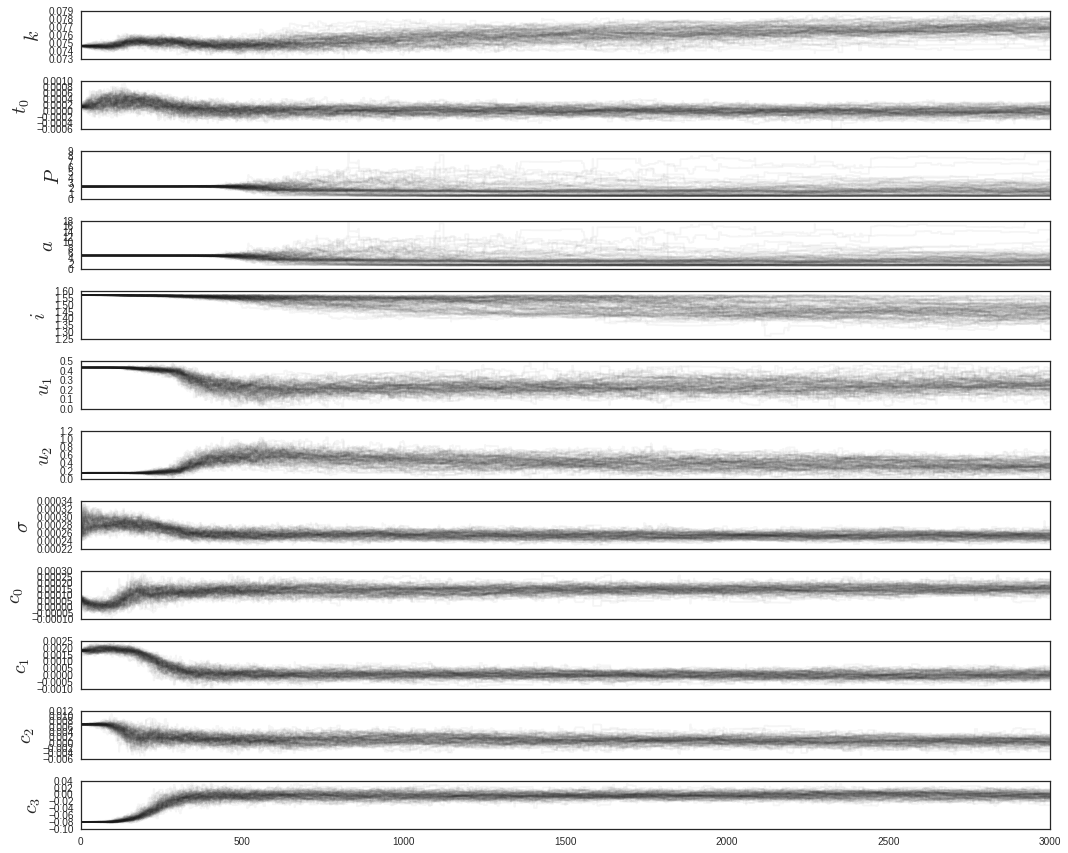

In [148]:
chain = sampler.chain
labels = ['${}$'.format(i) for i in r'k,t_0,P,a,i,u_1,u_2,\sigma,c_0,c_1,c_2,c_3'.split(',')]
with sb.axes_style('white'):
    fig, axs = pl.subplots(ndim, 1, figsize=(15,ndim), sharex=True)
    [axs.flat[i].plot(c, drawstyle='steps', color='k', alpha=4./nwalkers) for i,c in enumerate(chain.T)]
    for i,ax in enumerate(axs):
        ax.set_ylabel(labels[i], fontsize=20)
    fig.tight_layout()

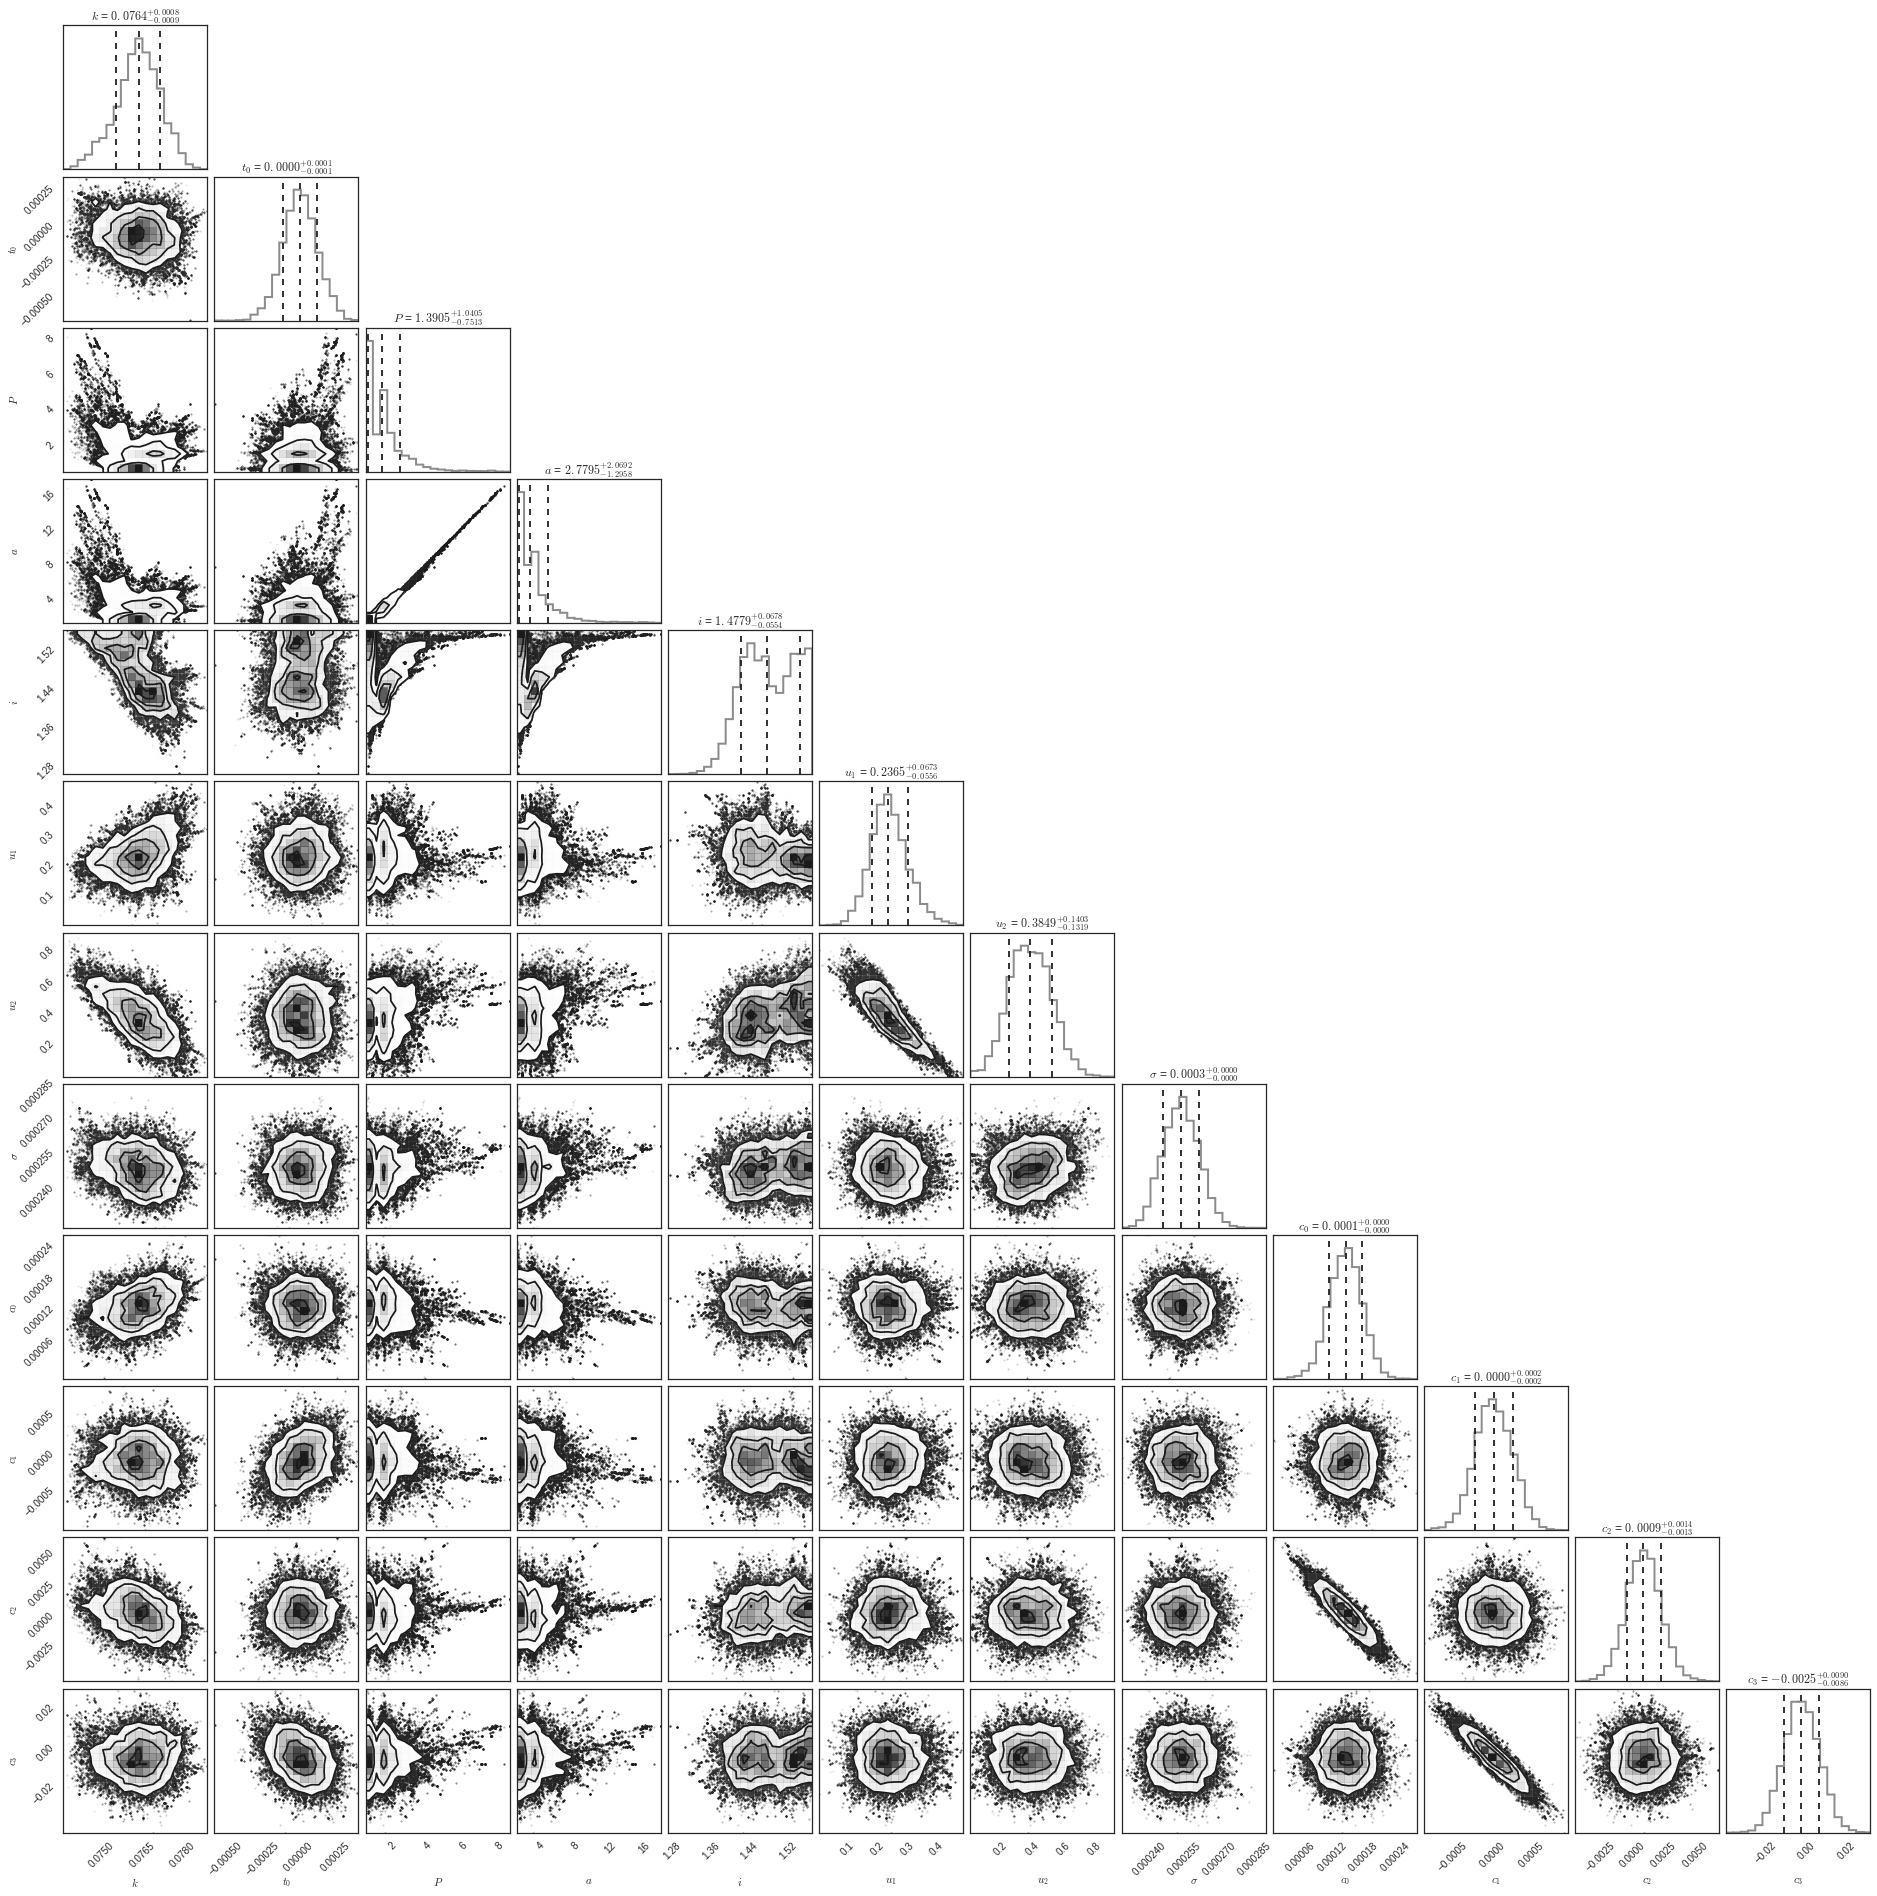

In [149]:
import corner
burn = 1000
thin = 1
fc = chain[:,burn::thin,:].reshape(-1, ndim)
hist_kwargs = dict(lw=2, alpha=0.5)
title_kwargs = dict(fontdict=dict(fontsize=12))

pl.figure()
with sb.axes_style('white'):
    corner.corner(fc, 
                  labels=labels,
#                   truths=truths,
                  hist_kwargs=hist_kwargs,
                  title_kwargs=title_kwargs,
                  show_titles=True, 
                  quantiles=[0.16,0.5,0.84],
                  title_fmt='.4f')
#     fig.tight_layout()

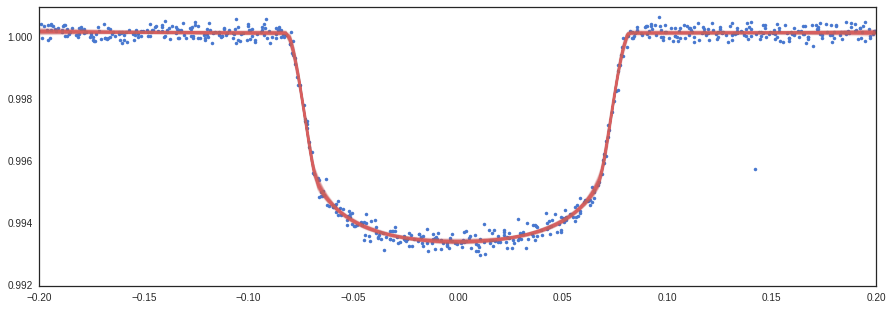

In [150]:
with sb.axes_style('white'):
    fig, ax = pl.subplots(1,1,figsize=(15,5))
    ax.plot(tf, ff, 'b.')
    for s in fc[np.random.randint(len(fc), size=128)]:
        ax.plot(tf, model(s, tf)+baseline(s, tf), 'r-', alpha=0.05)

### Stellar density

In [153]:
p, a = med[2:4]
simfit.util.rhostar(p,a)

<Quantity 0.2919900505631283 g / cm3>